In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
import ast
import csv
import itertools
import random
from itertools import product
import numpy as np
import pandas as pd

from loss_functions import *
from src.activation_functions import *
from src.batch_normalization import *
from src.data_preprocessing import *
from src.ensemble.cascade_correlation import CascadeCorrelation
from src.k_fold_cross_validation import *
from src.layer import *
from src.early_stopping import EarlyStopping
from src.neural_network import *
from src.optimizers import *
from src.random_search import *
from src.train_and_evaluate import Train
from src.utils import *

# from src.random_search import *

np.random.seed(0)

<!-- #### Data pre-processing for MONK Datasets  -->

In [4]:
X_train, y_train = load_data(MONK_NUM=2)
X_test, y_test = load_data(MONK_NUM=2, train=False)

one hot encoded data:  (169, 17)
one hot encoded data:  (432, 17)


In [5]:
X_train, X_val = train_test_split(X_train)
y_train, y_val = train_test_split(y_train)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [6]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))

Training set size: 135
Validation set size: 34


In [7]:
# Print the shape of the resulting datasets
for _ in [X_train, X_val, y_train, y_val]:
    print(f"the shape: ", _.shape)

the shape:  (135, 17)
the shape:  (34, 17)
the shape:  (135, 1)
the shape:  (34, 1)


In [37]:
param_distributions = {
    'hidden_size': [[3], [4], [5], [6], [8]],
    'hidden_activation': [Activation_Tanh, Activation_Leaky_ReLU, Activation_Sigmoid, Activation_ReLU],
    'batch_norm': [[True], [False]],
    'learning_rate': [1e-2, 1e-4, 1e-3, 2e-4,1e-6, 1e-5],
    'l1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'l2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'dropout_rate': [0.0, 0.1, 0.3],
    'batch_size': [8, 16, 32],
    'n_epochs': [100, 150, 200, 250, 300],
    'weight_decay': [0, 5e-2, 1e-2, 1e-3, 1e-4, 1e-5],
    'patience': [0, 20, 30, 50],
    'CC': [False],
    'weights_init': ['gaussian', 'gaussian_scaled', 'xavier', 'he', 'random'],
    # # Define combinations of hidden layer sizes and corresponding activations
    # 'hidden_configs': [
    #     {'hidden_size': [10], 'hidden_activation': [Activation_Tanh], 'batch_norm' : [True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_ELU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [32, 16], 'hidden_activation': [Activation_Leaky_ReLU, Activation_Sigmoid], 'batch_norm' : [False, True]},  
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [64, 32, 16], 'hidden_activation': [Activation_ReLU, Activation_ReLU, Activation_Tanh], 'batch_norm' : [True, False, True]},
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm': [True, False]}
    # ]   
}

TODO:

Create a seperate best_results csv file for each MONK 

In [51]:
best_hyperparams, best_performance = random_search(X_train=X_train, y_train=y_train, param_distributions=param_distributions, n_iters=50)  # adjust n_iters as needed

print(best_hyperparams)

[3] <class 'src.activation_functions.Activation_Sigmoid'> [0.1] [True]
Data shapes:
X_train: (108, 17), y_train: (108, 1)
Hyperparams: {'hidden_size': [3], 'hidden_activation': <class 'src.activation_functions.Activation_Sigmoid'>, 'batch_norm': [True], 'learning_rate': 1e-06, 'l1': 0.0001, 'l2': 0.0001, 'dropout_rate': 0.1, 'batch_size': 8, 'n_epochs': 300, 'weight_decay': 0.05, 'patience': 0, 'CC': False, 'weights_init': 'random'}
Epoch 0: Train Loss: 0.2516, Acc: 48.21% | Val Loss: 0.2489, Acc: 51.85%
Early stopping at epoch 0
Restoring model weights from epoch 0
Final Validation Accuracy: 0.5185
✅ Fold 1/5 | Validation Accuracy: 0.5185
[3] <class 'src.activation_functions.Activation_Sigmoid'> [0.1] [True]
Data shapes:
X_train: (108, 17), y_train: (108, 1)
Hyperparams: {'hidden_size': [3], 'hidden_activation': <class 'src.activation_functions.Activation_Sigmoid'>, 'batch_norm': [True], 'learning_rate': 1e-06, 'l1': 0.0001, 'l2': 0.0001, 'dropout_rate': 0.1, 'batch_size': 8, 'n_epoch

In [52]:
print(best_hyperparams)

{'hidden_size': [8], 'hidden_activation': <class 'src.activation_functions.Activation_Leaky_ReLU'>, 'batch_norm': [False], 'learning_rate': 0.001, 'l1': 1e-06, 'l2': 0.001, 'dropout_rate': 0.1, 'batch_size': 16, 'n_epochs': 300, 'weight_decay': 0.001, 'patience': 50, 'CC': False, 'weights_init': 'random', 'val_accuracy': np.float64(0.7925925925925926)}


GRID SEARCH

In [53]:
if best_hyperparams['CC']:
    model = CascadeCorrelation(input_size = 17, output_size= 1, activation=Activation_Leaky_ReLU, output_activation = Activation_Sigmoid)
else:
    model = NN(
        l1=best_hyperparams['l1'],
        l2=best_hyperparams['l2'],
        input_size=17,
        hidden_sizes=best_hyperparams['hidden_size'],
        output_size=1,
        hidden_activation=best_hyperparams['hidden_activation'],
        dropout_rates=[best_hyperparams['dropout_rate']],
        use_batch_norm=best_hyperparams['batch_norm']
    )
batch_size = best_hyperparams['batch_size']
learning_rate = best_hyperparams['learning_rate']
n_epochs = best_hyperparams['n_epochs']

[8] <class 'src.activation_functions.Activation_Leaky_ReLU'> [0.1] [False]


Data shapes:
X_train: (135, 17), y_train: (135, 1)
Hyperparams: {'hidden_size': [8], 'hidden_activation': <class 'src.activation_functions.Activation_Leaky_ReLU'>, 'batch_norm': [False], 'learning_rate': 0.001, 'l1': 1e-06, 'l2': 0.001, 'dropout_rate': 0.1, 'batch_size': 16, 'n_epochs': 300, 'weight_decay': 0.001, 'patience': 50, 'CC': False, 'weights_init': 'random', 'val_accuracy': np.float64(0.7925925925925926)}
Epoch 0: Train Loss: 0.3398, Acc: 53.37% | Val Loss: 0.3670, Acc: 50.00%
Epoch 10: Train Loss: 0.3358, Acc: 53.37% | Val Loss: 0.3450, Acc: 47.06%
Epoch 20: Train Loss: 0.2869, Acc: 58.43% | Val Loss: 0.3282, Acc: 55.88%
Epoch 30: Train Loss: 0.2693, Acc: 62.10% | Val Loss: 0.3151, Acc: 52.94%
Epoch 40: Train Loss: 0.2739, Acc: 62.80% | Val Loss: 0.3071, Acc: 50.00%
Epoch 50: Train Loss: 0.2790, Acc: 59.82% | Val Loss: 0.3016, Acc: 47.06%
Epoch 60: Train Loss: 0.2716, Acc: 59.82% | Val Loss: 0.2971, Acc: 47.06%
Epoch 70: Train Loss: 0.2402, Acc: 63.00% | Val Loss: 0.2948, Ac

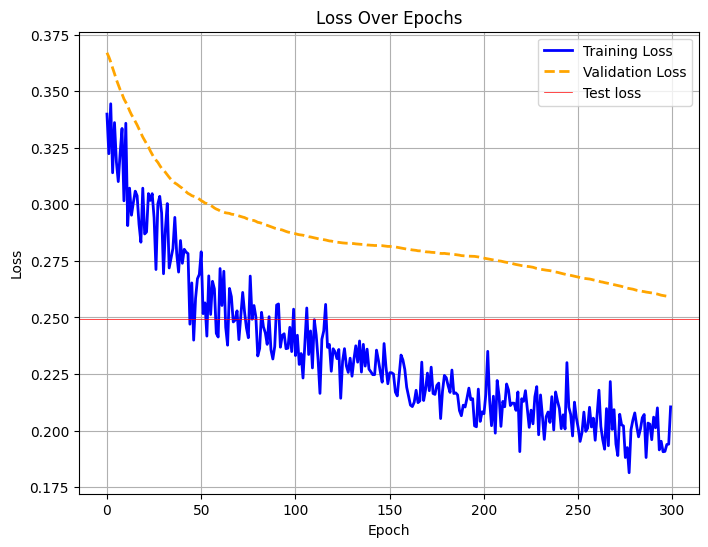

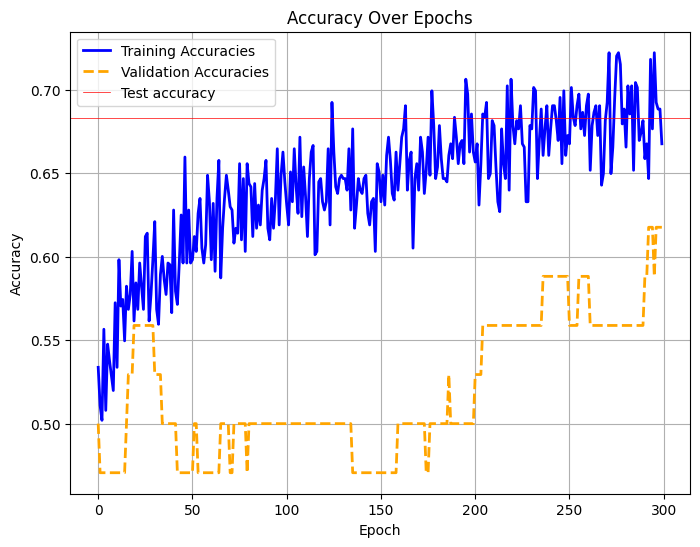

In [54]:
import copy

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

loss_function = MSE()
optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=best_hyperparams['weight_decay'])

# Initialize early stopping
early_stopping = EarlyStopping(patience=30, min_delta_loss=1e-5, min_delta_accuracy=0.001)

# Before training loop:
print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Hyperparams: {best_hyperparams}")
# print(f"Sample prediction: {model.forward(X_train[:1])}")
# print(f"Initial loss: {loss_function.forward(model.output, y_train[:1])}")

# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    batch_accuracies = []

    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        # Forward pass
        model.forward(X_batch, training=True)

        # Loss and accuracy
        loss = loss_function.forward(model.output, y_batch)
        predictions = np.round(model.output.squeeze())
        accuracy = np.mean(predictions == y_batch.squeeze())

        # Backward pass
        loss_function.backward(model.output, y_batch)
        dvalues = loss_function.dinputs

        assert dvalues.shape == model.output.shape, \
            f"Gradient shape mismatch: {dvalues.shape} vs {model.output.shape}"
        
        i = 0
        for layer in reversed(model.layers):
            i=-1
            layer.backward(dvalues)
            dvalues = np.array(layer.dinputs)

        # Update weights
        optimizer.pre_update_params()
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                optimizer.update_params(layer)
        optimizer.post_update_params()

        batch_losses.append(loss)
        batch_accuracies.append(accuracy)

    # Epoch summary
    epoch_loss = np.mean(batch_losses)
    epoch_acc = np.mean(batch_accuracies)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    X_val_input = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
    y_val_input = y_val.values if isinstance(y_val, (pd.Series, pd.DataFrame)) else y_val

    model.forward(X_val_input, training=False)
    val_loss = loss_function.forward(model.output, y_val_input)
    val_predictions = np.round(model.output.squeeze())
    val_accuracy = np.mean(val_predictions == y_val.squeeze())

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: ", end="")
        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc*100:.2f}% | ", end="")
        print(f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy*100:.2f}%")

    # Early stopping check
    early_stopping.on_epoch_end(
        current_loss=val_loss,
        current_accuracy=val_accuracy,
        model=model,
        epoch=epoch
    )

    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}")
        # Restore best weights
        print(f"Restoring model weights from epoch {early_stopping.best_epoch}")
        early_stopping.restore_weights(model)
        # Cascade correlation
        if isinstance(model, CascadeCorrelation):
            if model.is_limit_reached():
                break
            
            model.add_neuron()
            early_stopping.wait = 0
            early_stopping.patience -= int(early_stopping.patience / 10)
            early_stopping.stop_training = False
            print(f"Added new neuron at epoch {epoch} wiht val_loss {val_losses[-1]:.4f}")
            continue
        break

# Final evaluation
model.forward(X_val_input, training=False)
final_val_loss = loss_function.forward(model.output, y_val_input)
final_val_accuracy = np.mean(np.round(model.output.squeeze()) == y_val.squeeze())
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")


# Test set evaluation
model.forward(X_test, training=False)
test_loss = loss_function.forward(model.output.squeeze(), y_test)

predictions = np.round(model.output.squeeze())
# y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
test_accuracy = np.mean(predictions == y_test.squeeze())
print(f"Test Accuracy: {test_accuracy:.4f}")
print(predictions[:10].squeeze(), y_test[:10].squeeze())
# Plot training progress
plot_losses(train_losses, val_losses, test_loss,
            label1="Training Loss", label2="Validation Loss",
            title="Loss Over Epochs")

plot_accuracies(train_accuracies, val_accuracies, test_accuracy,
                label1="Training Accuracies", label2="Validation Accuracies",
                title="Accuracy Over Epochs")

In [55]:
print(train_losses, val_losses)

[np.float64(0.3398489716924185), np.float64(0.3223457424042728), np.float64(0.34440461381112797), np.float64(0.31392417824695174), np.float64(0.3360933550499354), np.float64(0.31874702912131186), np.float64(0.3100350228335478), np.float64(0.3227084066746971), np.float64(0.33351366716862374), np.float64(0.3015379887762332), np.float64(0.3357938627392547), np.float64(0.29058363767960743), np.float64(0.3071266944199474), np.float64(0.2951854157305734), np.float64(0.3007386240672425), np.float64(0.3057908267109718), np.float64(0.30377292214149537), np.float64(0.2912677131198914), np.float64(0.28324417993153744), np.float64(0.30711600540327244), np.float64(0.28688871936161536), np.float64(0.2877513172309813), np.float64(0.30472977577153326), np.float64(0.30171866147824894), np.float64(0.3046930292394523), np.float64(0.2940159967133824), np.float64(0.2711737525855775), np.float64(0.3001765179571719), np.float64(0.30351068379332363), np.float64(0.2961673897328168), np.float64(0.26931424015477

In [56]:
model.forward(X_test, training=False)
# Compute softmax probabilities for the test output
# print(X_test.shape, y_test.shape)
# print(model.output, y_test)
loss_function.forward(model.output.squeeze(), y_test)
# Calculate accuracy for the test set
predictions = np.round(model.output.squeeze())
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8773


In [57]:
class EnsembleNN:
    def __init__(self, n_models=5):
        self.models = []
        self.n_models = n_models
        self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
        

    def create_and_train_models(self, hyperparams):
        # Create and train multiple models with the same hyperparameters
        for i in range(self.n_models):
            model = NN(
                l1=hyperparams['l1'],
                l2=hyperparams['l2'],
                input_size=17,
                hidden_sizes=hyperparams['hidden_size'],
                output_size=1,
                hidden_activation=hidden_activation,
                dropout_rates=[hyperparams['dropout_rate']],
                use_batch_norm=hyperparams['batch_norm']
            )
            print(f"Training model {i+1}/{self.n_models}")
            # Train model using existing train_and_evaluate function
            self.train = Train(hyperparams, model)
            model, val_accuracy = self.train.train_and_evaluate(
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
            )
            self.models.append(model)
            print(f"Model {i+1} validation accuracy: {val_accuracy:.4f}")

    def predict(self, X):
        """Make predictions using majority voting"""
        predictions = []
        for model in self.models:
            model.forward(X, training=False)
            self.loss_activation.forward(
                model.output, np.zeros((X.shape[0], 2)))  # Dummy y values
            pred = np.argmax(self.loss_activation.output, axis=1)
            predictions.append(pred)

        # Majority voting
        predictions = np.array(predictions)
        final_predictions = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(),
            axis=0,
            arr=predictions
        )
        return final_predictions

In [ ]:
ensemble = EnsembleNN(n_models=5)

ensemble.create_and_train_models(best_hyperparams)

_ , test_accuracy = ensemble.train.test(X_test, y_test)

print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")

ensemble.train.plot(accuracy=True)

[8] <class 'src.activation_functions.Activation_Leaky_ReLU'> [0.1] [False]
Training model 1/5
Data shapes:
X_train: (135, 17), y_train: (135, 1)
Hyperparams: {'hidden_size': [8], 'hidden_activation': <class 'src.activation_functions.Activation_Leaky_ReLU'>, 'batch_norm': [False], 'learning_rate': 0.001, 'l1': 1e-06, 'l2': 0.001, 'dropout_rate': 0.1, 'batch_size': 16, 'n_epochs': 300, 'weight_decay': 0.001, 'patience': 50, 'CC': False, 'weights_init': 'random', 'val_accuracy': np.float64(0.7925925925925926)}
Epoch 0: Train Loss: 0.3447, Acc: 54.76% | Val Loss: 0.2979, Acc: 64.71%
Epoch 10: Train Loss: 0.2743, Acc: 66.47% | Val Loss: 0.2945, Acc: 61.76%
Epoch 20: Train Loss: 0.2497, Acc: 66.77% | Val Loss: 0.2911, Acc: 58.82%
